In [94]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import itertools
from time import time
import fasttext
from sklearn import preprocessing
from keras.utils import np_utils
from keras.layers import Dense, Embedding, Input, Reshape
from keras.layers import Dropout, MaxPooling1D, Conv1D, Conv2D, Flatten, LSTM, Softmax
from keras.models import Model
from keras.preprocessing import text, sequence
from nn_utils import TrainingHistory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import tensorflow as tf
from datetime import timedelta
from tensorflow.python.layers import base
import tensorflow.contrib.slim as slim
import keras.backend as K
import keras

In [12]:
base_data_dir = "data/Tobacco3482-OCR/"
list_dir = os.listdir(base_data_dir)
print(str(list_dir))
nbs = []
x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        x.append(txt.replace('\n', ' '))
        y.append(repo)
    nbs.append(len(files))
print(str(nbs))
x = np.array(x)
y = np.array(y)

['Advertisement', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']
[230, 599, 431, 567, 620, 188, 201, 265, 120, 261]


# Data distribution

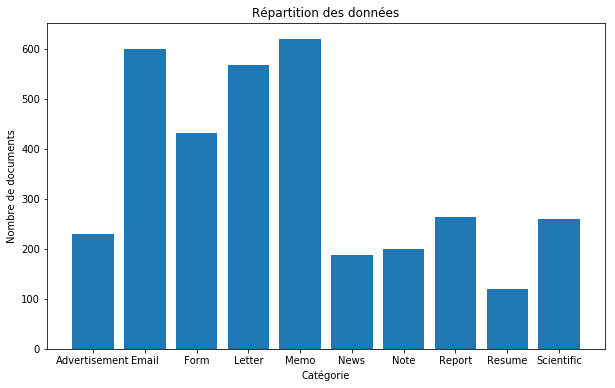

In [3]:
plt.figure(figsize=(10, 6))
plt.title("Répartition des données")
y_pos = np.arange(len(list_dir))
plt.bar(list_dir, nbs, align='center')
plt.xlabel('Catégorie')
plt.ylabel('Nombre de documents')
plt.savefig('repartition_donnees.png')
plt.show()

# Stat of document length

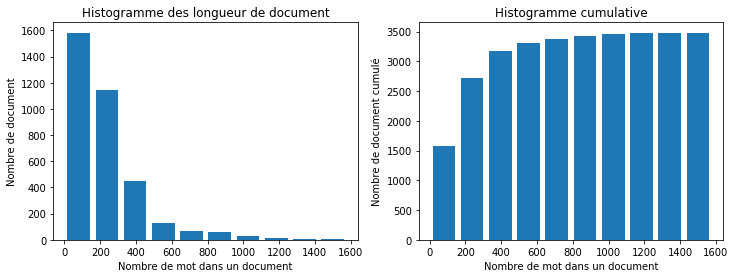

In [42]:
lens = []
for i in range(x.shape[0]):
    line = x[i].replace('\n', ' ').split()
    lens.append(len(line))
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Histogramme des longueur de document')
plt.hist(lens, bins=10, rwidth=0.8)
plt.xlabel('Nombre de mot dans un document')
plt.ylabel('Nombre de document')
plt.subplot(122)
plt.title('Histogramme cumulative')
plt.hist(lens, rwidth=0.8, cumulative=True)
plt.xlabel('Nombre de mot dans un document')
plt.ylabel('Nombre de document cumulé')
plt.savefig('longueur_doc.png')
plt.show()

# Preprocessing of data for FastText classifier and FastText word vector

In [20]:
x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(x, y, test_size=0.2)

In [21]:
with open('tobacco_nolabel.txt', 'w') as f:
    for i in x:
        f.write(i + '\n')

In [22]:
with open('tobacco_train.txt', 'w') as f:
    for i in range(x_train.shape[0]):
        line = x_train[i] + ' __label__' + y_train[i] + '\n'
        f.write(line)
with open('tobacco_test.txt', 'w') as f:
    for i in range(x_test.shape[0]):
        line = x_test[i] + ' __label__' + y_test[i] + '\n'
        f.write(line)

# Example of processed data

In [23]:
y[300]

'Email'

In [24]:
x[300]

"From: Meade, Mary Ann(MAD) on Fri, Jun 28, 1996 9:40 AM Subject: RE: B3G1F Banner stuff  To: Fawcett, Gina  Cc: DeMaio, Laurie  Gina - You or Laurie need to tell me what you want the instruction sht to say. Then we can set the type if you'd like.  VL62Sv6cL02"

# FastText Classification

In [25]:
true_labels = []
pred_labels = []
texts = []
clf = fasttext.supervised('tobacco_train.txt', 'model', epoch=100)
with open('tobacco_test.txt') as f:
    for line in f:
        spli = line.split("__label__")
        true_labels.append(spli[1].replace("\n", ""))
        texts.append(spli[0])
pred_labels = [e[0] for e in clf.predict(texts)]


In [48]:
import fastText
train_data = 'tobacco_train.txt'
valid_data = 'tobacco_test.txt'
model = fastText.train_supervised(input=train_data,
                                  epoch=100, 
                                  lr=1.0,
                                  wordNgrams=2,
                                  verbose=2,
                                  minCount=1)
model.test(valid_data)
pred = model.predict(valid_data)

true_labels = []
pred_labels = []
texts = []
with open('tobacco_test.txt') as f:
    for line in f:
        spli = line.split("__label__")
        true_labels.append(spli[1].replace("\n", ""))
        texts.append(spli[0])
        pred_labels.append(model.predict(spli[0])[0][0].split('__')[-1])

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
Normalized confusion matrix


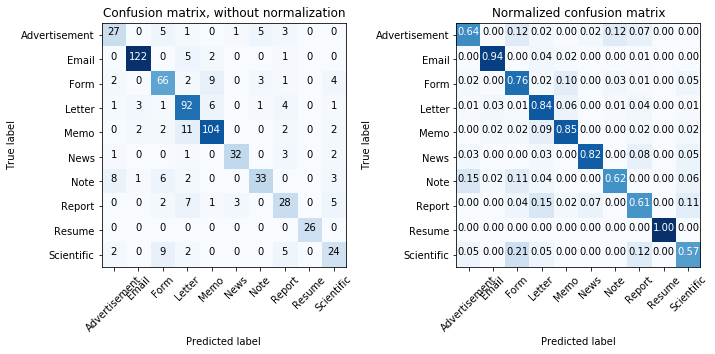

Test Accuracy: 0.7948350071736011
Test F1-score: 0.7948350071736012


In [26]:
class_names = np.unique(true_labels)
conf_mat = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,10))
plt.subplot(121)
plot_confusion_matrix(conf_mat, class_names, title='Confusion matrix, without normalization')
plt.subplot(122)
plot_confusion_matrix(conf_mat, class_names, normalize=True, title='Normalized confusion matrix')
plt.show()
print("Test Accuracy:", accuracy_score(true_labels, pred_labels))
print("Test F1-score:", f1_score(true_labels, pred_labels, average="micro"))

# Train word vectors with FastText Skipgram

In [107]:
tic = time()
model_skipgram = fasttext.skipgram('tobacco_nolabel.txt', 
                                   'ft_skipgram_100',
                                   min_count=3,
                                   dim=100,
                                   epoch=50,
                                   thread=16)
toc = time()
print(toc - tic)

38.538986682891846


# Neural network model for text classification

In [27]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH), \
           word_index


def class_str_2_ind(x_train, x_test, y_train, y_test):
    print('Converting data to trainable form...')
    le = preprocessing.LabelEncoder()
    CLASSES_LIST = np.unique(y_train)
    n_out = len(CLASSES_LIST)
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of test examples: ' + str(len(x_vec_test)))
    
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index


def get_embedding_index(vectors_file_path):
    embeddings_index = {}
    with open(vectors_file_path, 'r') as f:
        first_line = f.readline()
        #print(first_line)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index


def get_embedding_matrix(word_index, embedding_index):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print('Embedding matrix built.')        
    return embedding_matrix


def train_fit_predict(model, x_train, x_test, y_train, history):
    
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1,
              validation_split=VALIDATION_SPLIT)

    return model.predict(x_test)


def plot_conf_mat(y_test, y_predicted):
    conf_mat = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, title='Confusion matrix, without normalization')
    plt.subplot(122)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [49]:
def evaluation(vectors_file_path, print_sum=True, plot_mat=True):
    embedding_index = get_embedding_index(vectors_file_path)
    embedding_matrix = get_embedding_matrix(word_index, embedding_index)
    print('Building model...')
    model = get_model(embedding_matrix, word_index, print_sum=print_sum)
    history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)
    y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat, history).argmax(1)
    if plot_mat:
        plot_conf_mat(y_test, y_predicted)
    print("Test Accuracy:", accuracy_score(y_test, y_predicted))
    print("Test F1-score:", f1_score(y_test, y_predicted, average="micro"))
    return accuracy_score(y_test, y_predicted)

In [35]:
"""
base_data_dir = "data/Tobacco3482-OCR/"
list_dir = os.listdir(base_data_dir)
x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        x.append(txt)
        y.append(repo)
for i in range(len(x)):
    x[i] = x[i].replace('\n', ' ')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
"""
vectors_file_path = 'ft_skipgram_100.vec'
with open('ft_skipgram_100.vec') as f:
    first_line = f.readline().split()

# CNN-LSTM

In [38]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 500
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 80
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train_orig)
NUM_CLASS = len(CLASSES_LIST)

In [39]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train_orig,
                                                                                    x_test_orig,
                                                                                    y_train_orig,
                                                                                    y_test_orig)

Label categories: ['Advertisement' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report'
 'Resume' 'Scientific']
Converting data to trainable form...
Number of training examples: 2785
Number of test examples: 697


In [40]:
len(word_index)

73623

In [41]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    #model = Dropout(0.2)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    
    #model = Dropout(0.5)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    #model = Flatten()(model)
    model = LSTM(128, dropout=0.5, recurrent_dropout=0.5)(model)
    model = Dense(512, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model

Found 27469 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 100)          7362400   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 64)           19264     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 250, 64)           12352     
_____________________________________________

2506/2506 [==============================] - 3s 1ms/step - loss: 0.5393 - acc: 0.8021 - val_loss: 0.7982 - val_acc: 0.7455
Epoch 47/80
2506/2506 [==============================] - 3s 1ms/step - loss: 0.4984 - acc: 0.8228 - val_loss: 0.7846 - val_acc: 0.7599
Epoch 48/80
2506/2506 [==============================] - 3s 1ms/step - loss: 0.4818 - acc: 0.8288 - val_loss: 0.8034 - val_acc: 0.7384
Epoch 49/80
2506/2506 [==============================] - 3s 1ms/step - loss: 0.4946 - acc: 0.8224 - val_loss: 0.7761 - val_acc: 0.7491
Epoch 50/80
2506/2506 [==============================] - 3s 1ms/step - loss: 0.4503 - acc: 0.8400 - val_loss: 0.8140 - val_acc: 0.7634
Epoch 51/80
2506/2506 [==============================] - 3s 1ms/step - loss: 0.4820 - acc: 0.8356 - val_loss: 0.8296 - val_acc: 0.7527
Epoch 52/80
2506/2506 [==============================] - 3s 1ms/step - loss: 0.4839 - acc: 0.8324 - val_loss: 0.7886 - val_acc: 0.7455
Epoch 53/80
2506/2506 [==============================] - 3s 1ms/ste

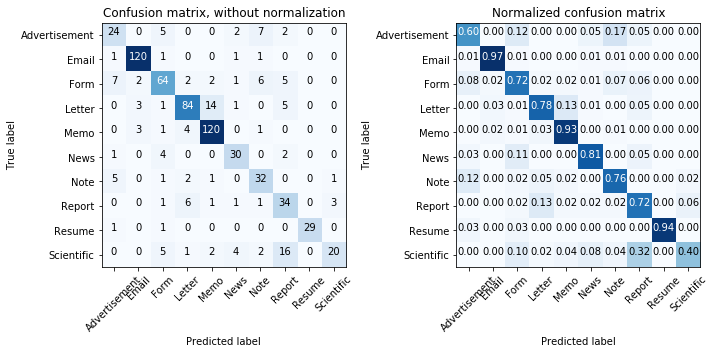

Test Accuracy: 0.7991391678622669
Test F1-score: 0.7948350071736012


0.7991391678622669

In [42]:
evaluation(vectors_file_path, print_sum=True, plot_mat=True)

# Pure CNN

In [47]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 500
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 50
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train_orig)
NUM_CLASS = len(CLASSES_LIST)

Found 27469 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 500, 100)          7362400   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 500, 64)           19264     
_________________________________________________________________
dropout_19 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 250, 64)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 250, 64)           12352     
_____________________________________________

2506/2506 [==============================] - 0s 89us/step - loss: 0.0876 - acc: 0.9701 - val_loss: 1.1449 - val_acc: 0.6559
Epoch 47/50
2506/2506 [==============================] - 0s 89us/step - loss: 0.0836 - acc: 0.9741 - val_loss: 1.1729 - val_acc: 0.6559
Epoch 48/50
2506/2506 [==============================] - 0s 89us/step - loss: 0.0753 - acc: 0.9745 - val_loss: 1.0919 - val_acc: 0.6631
Epoch 49/50
2506/2506 [==============================] - 0s 89us/step - loss: 0.0816 - acc: 0.9737 - val_loss: 1.0495 - val_acc: 0.6846
Epoch 50/50
2506/2506 [==============================] - 0s 88us/step - loss: 0.0707 - acc: 0.9781 - val_loss: 1.0792 - val_acc: 0.6774
Confusion matrix, without normalization
Normalized confusion matrix


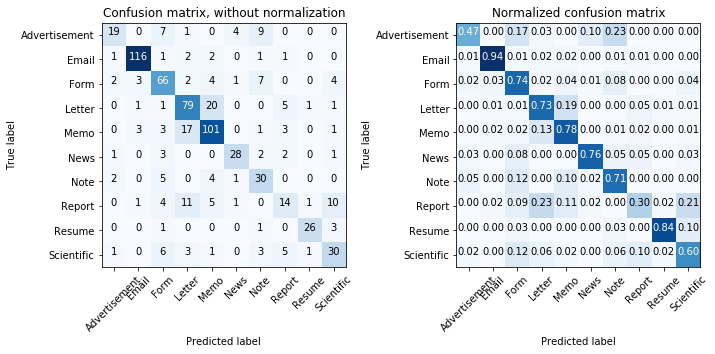

Test Accuracy: 0.7302725968436155
Test F1-score: 0.7302725968436155


0.7302725968436155

In [51]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    #model = Dropout(0.2)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    #model = MaxPooling1D(pool_size=2)(model)
    #model = Dropout(0.5)(model)
    #model = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    #model = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    #model = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    #model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    #model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(512, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model

evaluation(vectors_file_path, print_sum=True, plot_mat=True)

# TF-IDF

In [53]:
TF_IDF_FEATURES = 2000
'''
x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        x.append(txt)
        y.append(repo)
for i in range(len(x)):
    x[i] = x[i].replace('\n', ' ')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
'''
# Create document vectors
vectorizer = CountVectorizer(max_features=TF_IDF_FEATURES)
vectorizer.fit(x_train)
x_train_counts = vectorizer.transform(x_train_orig)
x_test_counts = vectorizer.transform(x_test_orig)

# With TF-IDF representation
tf_transformer = TfidfTransformer()
tfidf = tf_transformer.fit(x_train_counts)
x_train_tf = tfidf.transform(x_train_counts)
x_test_tf = tfidf.transform(x_test_counts)

# Neural Network with TF-IDF

In [54]:
def get_model():

    inp = Input(shape=(TF_IDF_FEATURES,))
    model = Dense(512, activation='relu')(inp)
    model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


def preprocess_label(y_train, y_test):
    CLASSES_LIST = np.unique(y_train)
    print('Label categories: ' + str(CLASSES_LIST))
    le = preprocessing.LabelEncoder()
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train) 
    y_test = le.transform(y_test) 
    train_y_cat = np_utils.to_categorical(y_train, NUM_CLASS)
    return train_y_cat, y_train, y_test


def class_str_2_ind_label(y_train, y_test):
    le = preprocessing.LabelEncoder()
    CLASSES_LIST = np.unique(y_train)
    n_out = len(CLASSES_LIST)
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    test_y_cat = np_utils.to_categorical(y_test, n_out)
    
    return y_train, y_test, train_y_cat, test_y_cat


In [55]:
# Model parameters
#MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 200
#EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 20
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train_orig)
NUM_CLASS = len(CLASSES_LIST)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               1024512   
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                5130      
Total params: 1,029,642
Trainable params: 1,029,642
Non-trainable params: 0
_________________________________________________________________
Train on 2506 samples, validate on 279 samples
Epoch 1/20
2506/2506 [==============================] - 1s 353us/step - loss: 2.1495 - acc: 0.3639 - val_loss: 1.9184 - val_acc: 0.4695
Epoch 2/20
2506/2506 [==============================] - 0s 37us/step - loss: 1.70

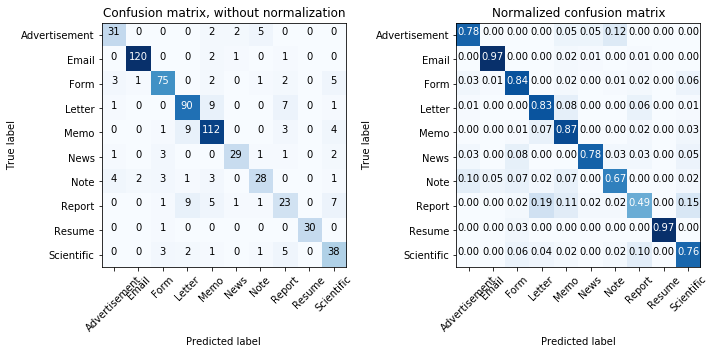

Test Accuracy: 0.8263988522238164
Test F1-score: 0.8263988522238165


In [56]:
y_train, y_test, train_y_cat, test_y_cat = class_str_2_ind_label(y_train_orig, y_test_orig)
model = get_model()
history = TrainingHistory(x_test_tf, y_test, CLASSES_LIST)
y_predicted = train_fit_predict(model, x_train_tf, x_test_tf, train_y_cat, history).argmax(1)
plot_conf_mat(y_test, y_predicted)
print("Test Accuracy:", accuracy_score(y_test, y_predicted))
print("Test F1-score:", f1_score(y_test, y_predicted, average="micro"))


# Self-attention model with TF-IDF

[Code](https://github.com/CyberZHG/keras-self-attention)

In [67]:
x_train_tf_dense = x_train_tf.toarray()
x_train_tf_dense = np.reshape(x_train_tf_dense, (x_train_tf_dense.shape[0], x_train_tf_dense.shape[1], 1))
x_test_tf_dense = x_test_tf.toarray()
x_test_tf_dense = np.reshape(x_test_tf_dense, (x_test_tf_dense.shape[0], x_test_tf_dense.shape[1], 1))

In [201]:
class ScaledDotProductAttention(keras.layers.Layer):
    
    def __init__(self,
                 **kwargs):
        """Initialize the layer.
        :param return_attention: Whether to return attention weights.
        :param history_only: Whether to only use history data.
        :param kwargs: Arguments for parent class.
        """
        #self.supports_masking = True
        #self.return_attention = return_attention
        #self.history_only = history_only
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        
    def call(self, inputs, squeeze=False, mask=None, **kwargs):
        query = inputs
        key = inputs
        value = inputs
        feature_dim = K.shape(query)[-1]
        e = K.batch_dot(query, key, axes=2) / K.sqrt(K.cast(feature_dim, dtype=K.floatx()))
        """
        if self.history_only:
            query_len, key_len = K.shape(query)[1], K.shape(key)[1]
            ones = tf.ones((query_len, key_len))
            e -= (ones - tf.matrix_band_part(ones, -1, 0)) * 1e9
        if isinstance(mask, list) and mask[-1] is not None:
            e -= (1.0 - K.cast(K.expand_dims(mask[-1], axis=-2), K.floatx())) * 1e9
        """
        a = keras.activations.softmax(e)
        v = K.batch_dot(a, value)
        if squeeze:
            v = K.squeeze(v, axis=2)
        #if self.return_attention:
        #    return [v, a]
        print(v.shape)
        return v


In [205]:
def get_model():

    inp = Input(shape=(TF_IDF_FEATURES,1))
    model = ScaledDotProductAttention()(inp)
    model = Reshape((TF_IDF_FEATURES,))(model)
    #model = Flatten()(model)
    #model = Dense(TF_IDF_FEATURES, activation='relu', input_shape=(TF_IDF_FEATURES,))(model)
    #model = Dropout(0)(model)
    model = Dense(128, activation='relu')(model)
    #model = Dropout(0.5)(model)
    #model = Flatten()(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


In [203]:
# Model parameters
#MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 200
#EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 20
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train_orig)
NUM_CLASS = len(CLASSES_LIST)

# Manually self attention

(2785, 2000, 1)


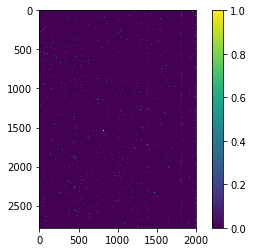

In [120]:
print(x_train_tf_dense.shape)
mat = x_train_tf_dense[:,:,0]
plt.imshow(x_train_tf_dense[:,:,0])
plt.colorbar()

0


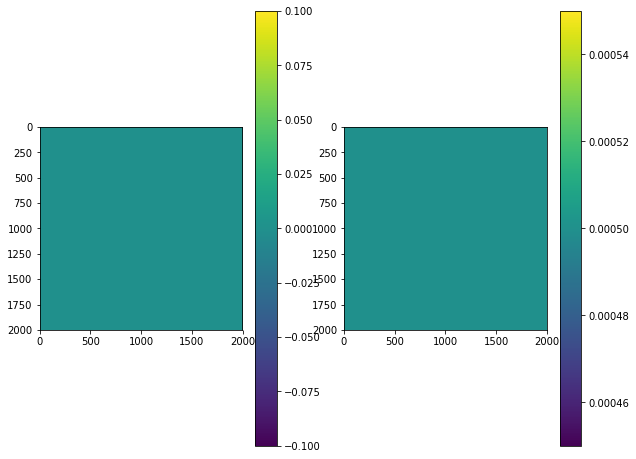

500


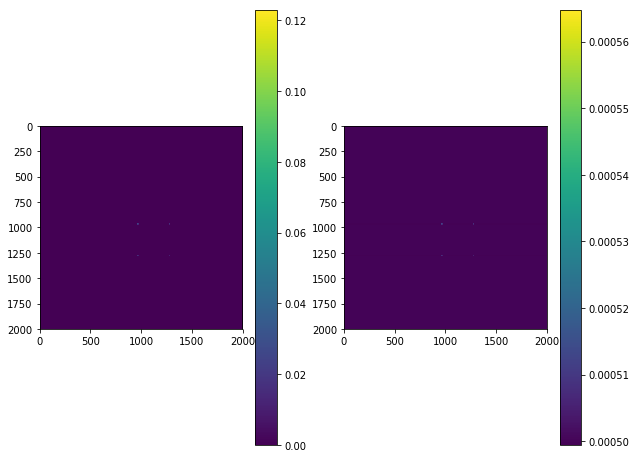

1000


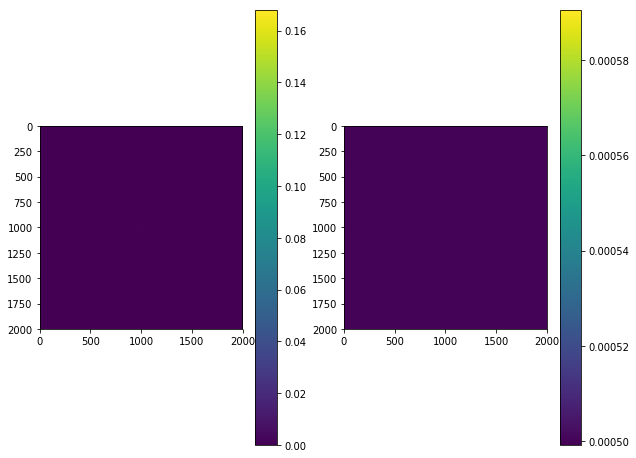

1500


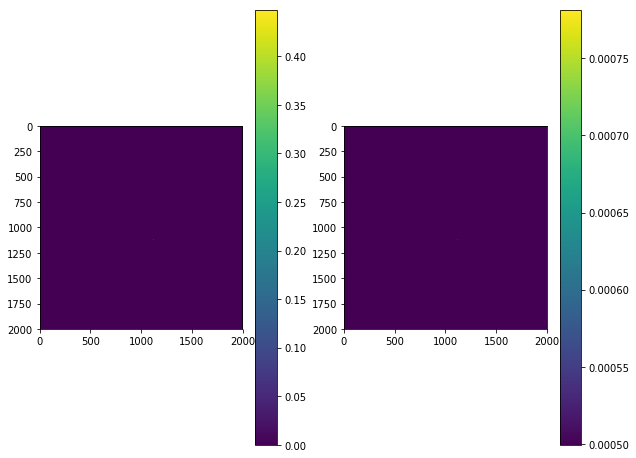

2000


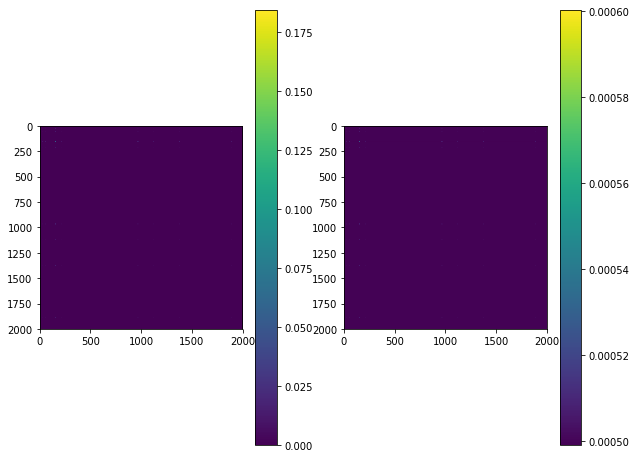

2500


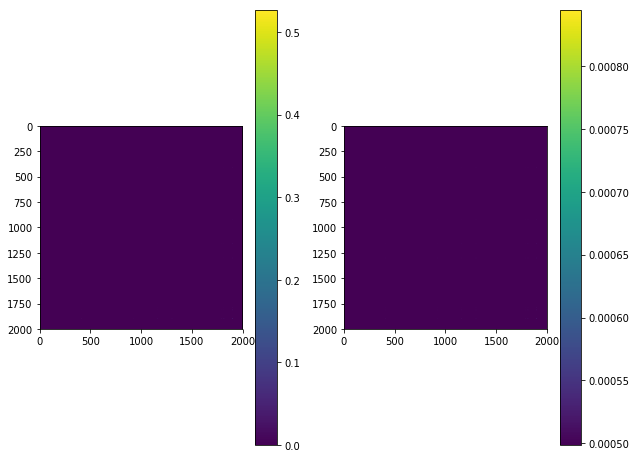

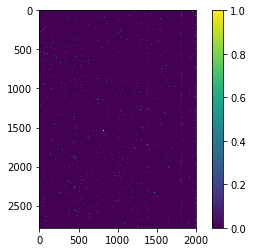

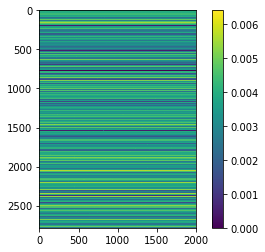

In [191]:
atts = np.empty(mat.shape)
for i in range(mat.shape[0]):
    if i % 500 == 0:
        print(i) 
        plt.figure(figsize=(10, 8))
        plt.subplot(121)
        plt.imshow(single)
        plt.colorbar()
        plt.subplot(122)
        plt.imshow(ps)
        plt.colorbar()
        plt.show()
    q = np.array(mat[i, :]).reshape((2000, 1))
    k = np.array(mat[i, :]).reshape((2000, 1))
    single = np.dot(q, k.T)
    ps = np.empty(single.shape)
    for j in range(single.shape[0]):
        ps[j,:]  = np.exp(single[j,:])
        ps[j,:] /= np.sum(ps[j,:])
    att = np.dot(ps, k)
    atts[i, :] = att.T
plt.figure()
plt.imshow(mat)
plt.colorbar()
plt.figure()
plt.imshow(atts)
plt.colorbar()

(?, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 2000, 1)           0         
_________________________________________________________________
scaled_dot_product_attention (None, 2000, 1)           0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 2000)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               256128    
_________________________________________________________________
dense_45 (Dense)             (None, 10)                1290      
Total params: 257,418
Trainable params: 257,418
Non-trainable params: 0
_________________________________________________________________
Train on 2506 samples, validate on 279 samples
Epoch 1/20
2506/2506 [==============================] - 3s 1ms/step - loss: 

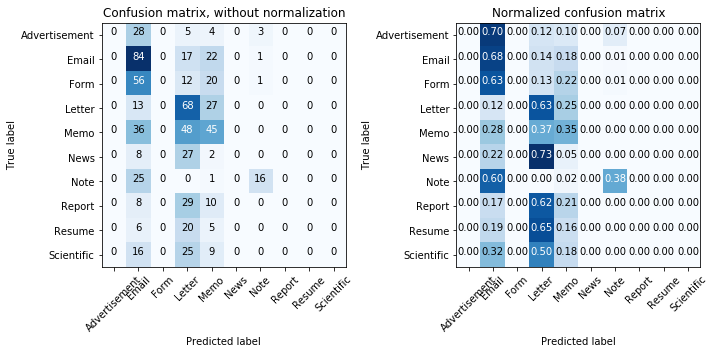

Test Accuracy: 0.30559540889526543
Test F1-score: 0.30559540889526543


In [206]:
#y_train, y_test, train_y_cat, test_y_cat = class_str_2_ind_label(y_train, y_test)
model = get_model()
history = TrainingHistory(x_test_tf_dense, y_test, CLASSES_LIST)
y_predicted = train_fit_predict(model, x_train_tf_dense, x_test_tf_dense, train_y_cat, history).argmax(1)
plot_conf_mat(y_test, y_predicted)
print("Test Accuracy:", accuracy_score(y_test, y_predicted))
print("Test F1-score:", f1_score(y_test, y_predicted, average="micro"))

# Self-attention with embedding

In [25]:
base_data_dir = "data/Tobacco3482-OCR/"
list_dir = os.listdir(base_data_dir)
x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        x.append(txt)
        y.append(repo)
for i in range(len(x)):
    x[i] = x[i].replace('\n', ' ')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
vectors_file_path = 'ft_skipgram_100.vec'
with open(vectors_file_path) as f:
    first_line = f.readline().split()

In [29]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 200
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 100
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train_orig)
NUM_CLASS = len(CLASSES_LIST)

Converting data to trainable form...
Number of training examples: 3133
Number of test examples: 349
Found 27469 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
(?, 200, 100)
(?, 200, 64)
(?, 200, 64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 200, 100)          8178700   
_________________________________________________________________
scaled_dot_product_attention (None, 200, 100)          0         
_________________________________________________________________
dense_44 (Dense)             (None, 200, 64)           6464      
_________________________________________________________________
dropout_28 (Dropout)         (None, 200, 64)           0         
_____________________________________

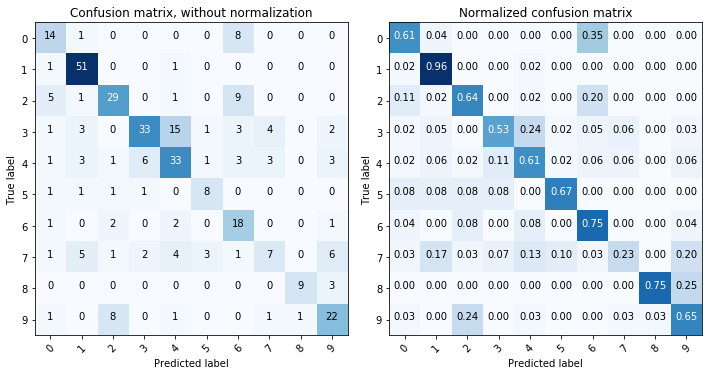

Test Accuracy: 0.6418338108882522


0.6418338108882522

In [31]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    model = ScaledDotProductAttention()(model)
    model = Dense(64, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = ScaledDotProductAttention()(model)
    model = Dense(64, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = ScaledDotProductAttention()(model)
    model = Dense(64, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Flatten()(model)
    
    #model = Dense(128, activation='relu')(model)
    #model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train_orig,
                                                                                    x_test_orig,
                                                                                    y_train_orig,
                                                                                    y_test_orig)
evaluation(vectors_file_path, print_sum=True, plot_mat=True)

# Tensorflow NN version with self-attention 

In [19]:
class TextCNN(object):
    """Text Classification, CNN Model"""
    
    def __init__(self, config):
        self.config = config
        # inputs
        self.input_x = tf.placeholder(tf.float32,
                                      [None, self.config.tf_idf_features], 
                                      name='input_x')
        self.input_y = tf.placeholder(tf.float32,
                                      [None, self.config.num_classes],
                                      name='input_y')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        self.self_attention()
        slim.model_analyzer.analyze_vars(tf.trainable_variables(), print_info=True)
    
    def self_attention(self):
        """Self Attention Model"""
        with tf.name_scope("self_attention"):
            # inputs shape : [batch, tf_idf_features]
            
            # self_attention layer
            self_att = tf.matmul(self.input_x, self.input_x, transpose_b=True)
            self_att = tf.nn.softmax(self_att)
            self_att = tf.matmul(self_att, self.input_x)
            fc = tf.layers.dense(self_att, units=512, activation=tf.nn.relu, name='fc1')
            fc_dropout = tf.contrib.layers.dropout(fc, keep_prob=self.keep_prob)
            self_att = tf.matmul(fc_dropout, fc_dropout, transpose_b=True)
            self_att = tf.nn.softmax(self_att)
            self_att = tf.matmul(self_att, fc_dropout)
            fc = tf.layers.dense(self_att, units=512, activation=tf.nn.relu, name='fc2')
            fc_dropout = tf.contrib.layers.dropout(fc, keep_prob=self.keep_prob)
        
        with tf.name_scope("score"):
            self.logits = tf.layers.dense(fc_dropout, units=self.config.num_classes, name='fc3')
            self.y_pred_cls = tf.argmax(tf.nn.softmax(self.logits), 1)

        with tf.name_scope("optimize"):
            # loss function, cross entropy
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,
                                                                    labels=self.input_y)
            self.loss = tf.reduce_mean(cross_entropy)
            # opptimizer
            self.optim = tf.train.AdamOptimizer(learning_rate=self.config.learning_rate).minimize(self.loss)
        
        
        with tf.name_scope("accuracy"):
            # accuracy
            correct_pred = tf.equal(tf.argmax(self.input_y, 1), self.y_pred_cls)
            self.acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Run self-attention model

In [20]:
tf.reset_default_graph()

def get_time_diff(start_time):
    """get time passed"""
    end_time = time()
    time_diff = end_time - start_time
    return timedelta(seconds=int(round(time_diff)))


def batch_iter(x, y, batch_size=128):
    """generate batch data"""
    data_len = len(x)
    num_batch = int((data_len - 1) / batch_size) 
    if (data_len - 1) % batch_size != 0:
        num_batch = num_batch + 1
    
    indices = np.random.permutation(np.arange(data_len))
    x_shuffle = x[indices]
    y_shuffle = y[indices]
    
    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_shuffle[start_id:end_id], y_shuffle[start_id:end_id]
        
def feed_data(model, x_batch, y_batch, keep_prob):
    feed_dict = {
        model.input_x: x_batch,
        model.input_y: y_batch,
        model.keep_prob: keep_prob
    }
    return feed_dict

def evaluate(model, sess, x_, y_):
    """evaluate the accuracy and loss on an example"""
    data_len = len(x_)
    batch_eval = batch_iter(x_, y_, 128)
    total_loss = 0.0
    total_acc = 0.0
    for x_batch, y_batch in batch_eval:
        batch_len = len(x_batch)
        feed_dict = feed_data(model, x_batch, y_batch, 1.0)
        loss, acc = sess.run([model.loss, model.acc], feed_dict=feed_dict)
        total_loss += loss * batch_len
        total_acc += acc * batch_len

    return total_loss / data_len, total_acc / data_len

def train(model, x_train, y_train, config):
    """
    print("Configuring TensorBoard and Saver...")
    # config Tensorboard，delete tensorboard folder for re-training
    tensorboard_dir = 'tensorboard/textcnn'
    if not os.path.exists(tensorboard_dir):
        os.makedirs(tensorboard_dir)
    
    tf.summary.scalar("loss", model.loss)
    tf.summary.scalar("accuracy", model.acc)
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(tensorboard_dir)
    
    # config saver
    saver = tf.train.Saver()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    print("Loading training and validation data...")
    start_time = time.time()
    x, y = process_datasets(train_dir, cat_to_id,
                            max_length=config.seq_length,
                            vocab_size=config.vocab_size)
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1)
    time_diff = get_time_diff(start_time)
    print("Time usage:", time_diff)
    """
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
    # Create session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #writer.add_graph(session.graph

        print("Training and evaluating...")
        start_time = time()
        total_batch = 0 # total batch
        best_acc_val = 0.0 # best validation set accurary
        last_improved = 0 # record last improved batch
        # if more than 1000 batches, we don't get improvement, we terminate training phase
        require_improvement = 1000
        
        flag = False
        for epoch in range(config.num_epochs):
            print("Epoch:", epoch + 1)
            batch_train = batch_iter(x_train, y_train, config.batch_size)
            for x_batch, y_batch in batch_train:
                        
                feed_dict = feed_data(model, x_batch, y_batch, config.dropout_keep_prob)
                
                #if total_batch % config.save_per_batch == 0:
                #    s = sess.run(merged_summary, feed_dict=feed_dict)
                #    writer.add_summary(s, total_batch)
                """    
                feed_dict = {
                    model.input_x: x_batch,
                    model.input_y: y_batch,
                    model.keep_prob: config.dropout_keep_prob
                }
                """
                if total_batch % config.print_per_batch == 0:
                    feed_dict[model.keep_prob] = 1.0
                    loss_train, acc_train = sess.run([model.loss, model.acc],
                                                     feed_dict=feed_dict)
                    loss_val, acc_val = evaluate(model, sess, x_val, y_val)
                    
                    if acc_val > best_acc_val:
                        # Save the best result
                        best_acc_val = acc_val
                        last_improved = total_batch
                        #saver.save(sess=sess, save_path=save_path)
                        improved_str = '*'
                    else:
                        improved_str = ''
                        
                    time_diff = get_time_diff(start_time)
                    msg = 'Iter: {0:>6}, Train Loss: {1:>6.2}, Train Acc: {2:>7.2%},' \
                      + ' Val Loss: {3:>6.2}, Val Acc: {4:>7.2%}, Time: {5} {6}'
                    print(msg.format(total_batch, loss_train, acc_train, loss_val,
                                     acc_val, time_diff, improved_str))
                    
                sess.run(model.optim, feed_dict=feed_dict) # run optimization
                total_batch += 1
                
                if total_batch - last_improved > require_improvement:
                    print("No optimization for a long time, auto-stopping...")
                    flag = True
                    break
            if flag:
                break
                
def test(model, x_test, y_test, config):
    print("Loading test data...")
    start_time = time()
    #x_test, y_test = process_datasets(test_dir, cat_to_id, conf)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #saver = tf.train.Saver()
        #saver.restore(sess=sess, save_path=save_path)
        
        print("Testing...")
        loss_test, acc_test = evaluate(model, sess, x_test, y_test)
        msg = 'Test Loss: {0:>6.2}, Test Acc: {1:>7.2%}'
        print(msg.format(loss_test, acc_test))
        
        batch_size = config.batch_size
        data_len = len(x_test)
        num_batch = (data_len - 1) / batch_size
        if (data_len - 1) % batch_size != 0:
            num_batch += 1
        
        y_test_cls = np.argmax(y_test, 1)
        y_pred_cls = np.zeros(shape=len(x_test), dtype=np.int32)
        for i in range(num_batch):
            start_id = i * batch_size
            end_id = ((i + 1) * batch_size, data_len)
            elmo_context_input_ = sess.run(
                    [elmo_context_input['weighted_op']],
                    feed_dict={context_token_ids: x_test[start_id:end_id]}
                )
            feed_dict = {
                model.input_x: elmo_context_input,
                model.keep_prob: 1.0
            }
            y_pred_cls[start_id:end_id] = sess.run(model.y_pred_cls, feed_dict=feed_dict)
        
        print("Precision, Recall and F1-Score...")
        print(metrics.classification_report(y_test_cls, y_pred_cls, target_names=categories))
        
        #print("Confusion Matrix...")
        #cm = metrics.confusion_matrix(y_test_cls, y_pred_cls)
        plot_conf_mat(y_test, y_predicted)
        print("Test Accuracy:", accuracy_score(y_test, y_predicted))
        
        time_diff = get_time_diff(start_time)
        print("Time usage: ", time_diff)


In [21]:
def run_self_attention():
    #if argv not in ['train', 'test']:
    #    raise ValueError("Wrong argument.")
        
    #print("Configuring CNN Model...")
    config = TCNNConfig()
    #words, word_to_id = read_vocab(vocab_dir)
    #config.vocab_size = len(words)
    model = TextCNN(config)
    
    #if argv == 'train':
    train(model, x_train_tf.toarray(), train_y_cat, config)
    #else:
    
    train(model, x_test_tf.toarray(), test_y_cat, config)

In [22]:
class TCNNConfig(object):
    """CNN parrameters config"""
    embedding_dim = 600  # embedding_size
    seq_length = 2000  # max length for each news
    tf_idf_features = 4000
    num_classes = NUM_CLASS  
    num_filters = 32  # number of filters
    kernel_size = 5  # conv kernel size
    vocab_size = 185734

    hidden_dim = 512  # number of units in fc1
    
    dropout_keep_prob = 0.5 
    learning_rate = 1e-3

    batch_size = 128  
    num_epochs = 20  

    print_per_batch = 100  
    save_per_batch = 10  # save into tensorboard

run_self_attention()

---------
Variables: name (type shape) [size]
---------
fc1/kernel:0 (float32_ref 4000x512) [2048000, bytes: 8192000]
fc1/bias:0 (float32_ref 512) [512, bytes: 2048]
fc2/kernel:0 (float32_ref 512x512) [262144, bytes: 1048576]
fc2/bias:0 (float32_ref 512) [512, bytes: 2048]
fc3/kernel:0 (float32_ref 512x10) [5120, bytes: 20480]
fc3/bias:0 (float32_ref 10) [10, bytes: 40]
Total size of variables: 2316298
Total bytes of variables: 9265192
Training and evaluating...
Epoch: 1
Iter:      0, Train Loss:    2.3, Train Acc:   5.47%, Val Loss:    2.3, Val Acc:   5.38%, Time: 0:00:00 *
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Iter:    100, Train Loss:    2.2, Train Acc:  19.53%, Val Loss:    2.1, Val Acc:  16.49%, Time: 0:00:01 *
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Iter:    200, Train Loss:    2.2, Train Acc:  13.28%, Val Loss:    2.1, Val Acc:  16.49%, Time: 0:00:01 
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Iter:    300, Train Loss:    2.2, Train Acc:  14.06%, Val Loss:  